#### Домашнее задание №4. Алгоритм построения дерева решений

In [2]:
##### Задача 1: 
#В коде из методички реализуйте один или несколько критериев останова: минимальное количество объектов в листе (min_leaf),
#максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции build_tree и
#проверьте ее работоспособность с помощью визуализации дерева.

In [ ]:
#Добавим изменения в функцию find_best_split и build_tree и убедимся в том, что:

#1. Деревья решений без критериев останова могут восстанавливать сложные зависимости на тренировочной выборке, но склонны к 
# переобучению на тестовой выборке, а значит такие деревья непригодны для построения прогнозов;
#2. Условия на минимальное количество объектов в листе, максимальную глубину дерева и максимальное количество листьев
# способствуют построению более "простых" деревьев, дающих более устойчивый прогноз:

# -- чем меньше глубина дерева, тем меньше переменных мы используем для прогноза. Используем только переменные с максимальной
# значимостью, дающие максимальный прирост информации;
# -- чем больше объектов в листе мы фиксируем, тем более устойчив прогноз дерева на тестовой выборке;
# -- чем меньше объектов в листе, тем больше дерево старается "уловить" частные закономерности, не выявляя общей закономерности
# в данных;
# -- чем меньше количество листьев, тем более устойчив прогноз на тестовой выборке;

# Перечисленные гиперпараметры необходимо настроивать для каждой конкретной задачи на валидационном множестве.

* [Дерево без критерия останова слишком переобучено: точность на тренировочной выборке = 100%, на тестовой 90%](#without)
* [Дерево с условием на кол-во объектов в листе: точность на тренировочной выборке = 95%, на тестовой 93%](#withleaf)
* [Дерево с условием на глубину и кол-во листьев](#withdepth)

In [15]:
#Импортируем необходимые библиотеки:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np

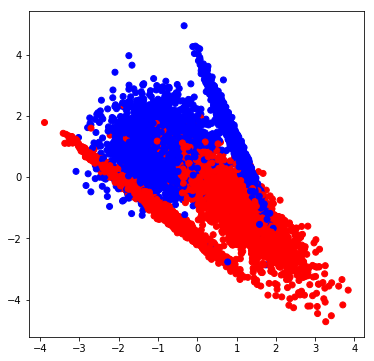

In [61]:
#Cгенерируем данные и визуализируем их
classification_data, classification_labels = datasets.make_classification(n_samples = 10000,
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=2, 
                                                      random_state=5)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(classification_data[:,0], classification_data[:,1], 
              c=classification_labels, cmap=colors)

In [62]:
# Реализуем класс узла c обязательными аргументами для экземпляров класса:
#-- индекс признака, по которому ведется сравнение с порогом в узле
#-- значение порога
#-- поддерево, удовлетворяющее условию в узле
#-- поддерево, не удовлетворяющее условию в узле

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [63]:
# И класс терминального узла (листа) с обязательными аргументами для экземпляров класса:
#-- дата
#-- лейблы: 0 или 1
#-- функция предикт

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction     

In [64]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [65]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [66]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    #индексы объектов, которые по разбиению t идут налево
    left = np.where(data[:, index] <= t)
    #индексы объектов, которые по разбиению t идут направо
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [80]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [81]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [82]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [83]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [84]:
# Разобьем выборку на обучающую и тестовую: 70/30%

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [85]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

#### Переобученное дерево <a class='anchor' id='without'>

In [86]:
# Напечатаем ход нашего дерева
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'


def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction) 
                  + ', объектов = ' + str(len(node.labels)) 
                  + ColorText.END)
        return

    # Выведем значение индекса и порога на этом узле
    print(ColorText.GREEN + spacing + ' УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "   ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "   ")
    
print_tree(my_tree)

 УЗЕЛ: индекс = 1, порог = -0.06
--> Левая ветка:
    УЗЕЛ: индекс = 1, порог = -0.48
   --> Левая ветка:
       УЗЕЛ: индекс = 0, порог = 1.39
      --> Левая ветка:
          УЗЕЛ: индекс = 0, порог = -1.74
         --> Левая ветка:
             УЗЕЛ: индекс = 1, порог = -0.56
            --> Левая ветка:
                ЛИСТ: прогноз = 1, объектов = 5
            --> Правая ветка:
                ЛИСТ: прогноз = 0, объектов = 1
         --> Правая ветка:
             УЗЕЛ: индекс = 1, порог = -0.73
            --> Левая ветка:
                УЗЕЛ: индекс = 0, порог = -1.39
               --> Левая ветка:
                   УЗЕЛ: индекс = 1, порог = -0.85
                  --> Левая ветка:
                      ЛИСТ: прогноз = 1, объектов = 4
                  --> Правая ветка:
                      ЛИСТ: прогноз = 0, объектов = 3
               --> Правая ветка:
                   УЗЕЛ: индекс = 1, порог = -1.28
                  --> Левая ветка:
                      УЗЕЛ: индекс 

                                                                                        ЛИСТ: прогноз = 1, объектов = 8
                                                                                    --> Правая ветка:
                                                                                        ЛИСТ: прогноз = 0, объектов = 1
                                                                                 --> Правая ветка:
                                                                                     ЛИСТ: прогноз = 1, объектов = 13
                                                                              --> Правая ветка:
                                                                                  УЗЕЛ: индекс = 0, порог = -1.1
                                                                                 --> Левая ветка:
                                                                                     ЛИСТ: прогноз = 0, объектов = 1
                 

In [87]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [88]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [89]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [90]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

100.0

In [91]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

90.96666666666667

Text(0.5,1,'Test accuracy=90.97')

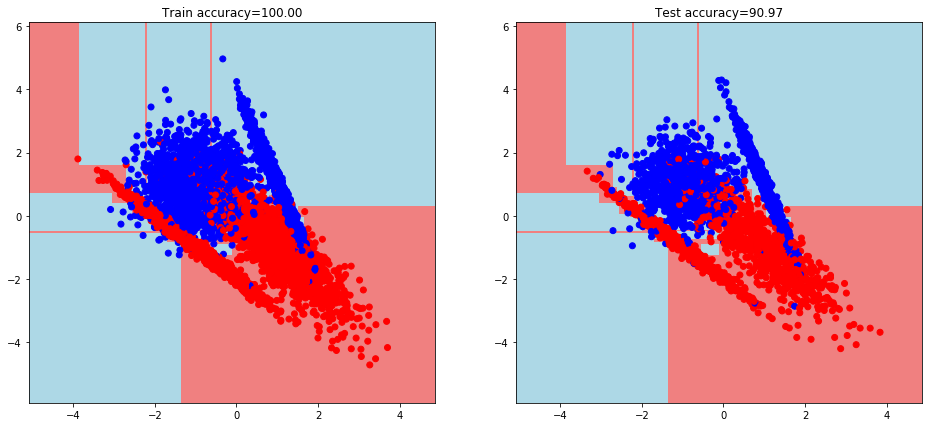

In [92]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [ ]:
#Видно, что дерево постаралось "уловить" частные закономерности, не выявляя общей закономерности в данных.
#Добавим условие на количество объектов в листе - min_leaf = 10

#### Дерево с уловием на минимальное кол-во объектов в листе равном 10 <a class='anchor' id='withleaf'>

In [96]:
# Внесем изменения в функцию find_best_split и снова посмотрим на качество разбиения на тестовой выборке:

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 10

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [97]:
my_tree = build_tree(train_data, train_labels)

In [98]:
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)

In [99]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

95.18571428571428

In [100]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

93.03333333333333

Text(0.5,1,'Test accuracy=93.03')

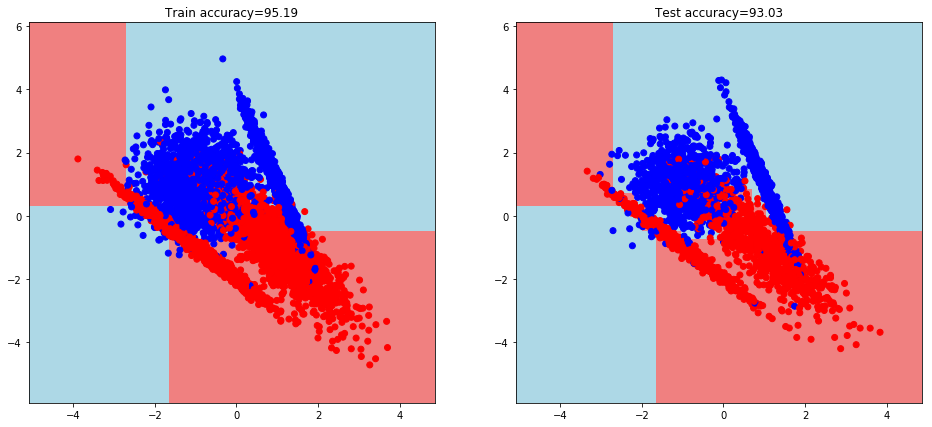

In [101]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [ ]:
#Точность на тренировочной выборке повысилась до 93%: дерево выявляет общую закономерность, "не впадая в частности"
#Добавим условия на глубину и максимальное количество листьев:

#### Переобученное дерево <a class='anchor' id='withdepth'>

In [106]:
# Добавляем критерии останова в функцию build_tree: здесь ошибка, которую мне не удалось исправить, не понимаю, где ошибка
# в функции...=(

def build_tree_new(data, labels, max_depth, max_leaf):

    global depth
    global leaf
    
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    depth += 1
    leaf += 2 
    
    if depth > max_depth or leaf > max_leaf:
        return Leaf(data, labels)
        
    # Рекурсивно строим два поддерева
    true_branch = build_tree_new(data, labels, max_depth, max_leaf)
    false_branch = build_tree_new(data, labels, max_depth, max_leaf)

    return Node(index, t, true_branch, false_branch)

In [107]:
# Построим дерево по обучающей выборке, задав максимальную длину дерева 2:
depth = 0
leaf = 0
my_tree = build_tree_new(train_data, train_labels, 5, 5)

In [108]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [109]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [110]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

50.4

In [111]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

49.266666666666666

Text(0.5,1,'Test accuracy=49.27')

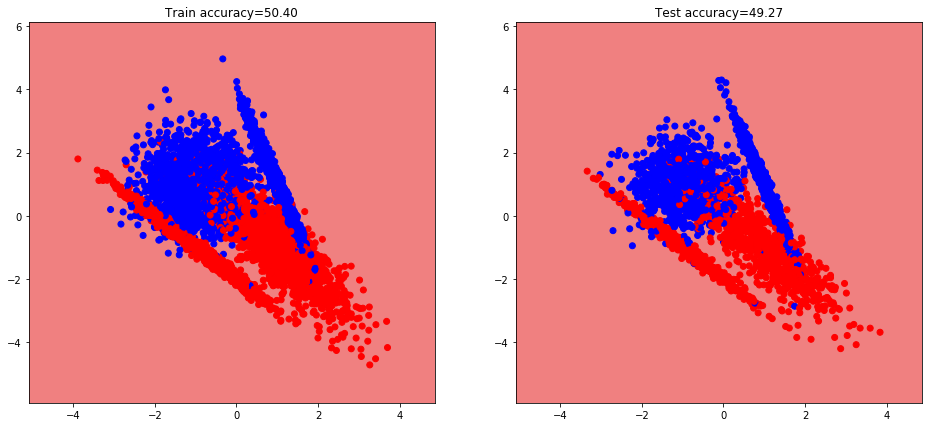

In [112]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')